![alt text](header_workflow.png)

### ML-based model compression 

#### Libraries

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2026-01-13 20:26:01.163933: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 20:26:01.208039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 20:26:01.904451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Enable GPU 

In [2]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  0


2026-01-13 20:26:02.735184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2026-01-13 20:26:02.735234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mareKaleido
2026-01-13 20:26:02.735241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mareKaleido
2026-01-13 20:26:02.735393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2026-01-13 20:26:02.735418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2026-01-13 20:26:02.735423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


#### Load dataset

In [3]:
# Cargar dataset MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0            # Normalización

##### Label selection for the binary classification

Filter images that only contain numbers 1 and 9


In [4]:
train_filter = np.where((y_train == 1) | (y_train == 9))
test_filter = np.where((y_test == 1) | (y_test == 9))

x_train = x_train[train_filter]
y_train = y_train[train_filter]
x_test = x_test[test_filter]
y_test = y_test[test_filter]

In [5]:
# Labels to binary format
y_train_binary = np.where(y_train == 1, 0, 1)  # 1 -> 0, 9 -> 1
y_test_binary = np.where(y_test == 1, 0, 1)  # 1 -> 0, 9 -> 1

In [6]:
# One-hot Encoding
y_train_binary = to_categorical(y_train_binary, num_classes=2, dtype=int)
y_test_binary = to_categorical(y_test_binary, num_classes=2, dtype=int)

### Model definition

The architecture is defined in a quantized manner

In [7]:

def build_model():
    # Fixed point precision
    kernelQ = "quantized_bits(8,3,alpha=1)"
    biasQ = "quantized_bits(8, 3,alpha=1)"
    activationQ = 'quantized_bits(16,6)'

    modelQ = Sequential(
                [   
                    
                    QDense(5, name='fc1_input',
                            input_shape=(28 * 28,),
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu_input'),

                    QDense(7, name='fc1',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu1'),

                    QDense(10, name='fc2',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    QActivation(activation= activationQ ,  name='relu2'),
                    
                    QDense(2, name='output',
                            kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                            kernel_initializer='lecun_uniform'),
                    Activation(activation='sigmoid', name='sigmoid')
                
                ],

            )
    return modelQ



In [8]:
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

### Build model

In [9]:
modelQ = build_model()

2026-01-13 20:26:03.161963: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x35febcf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-13 20:26:03.162022: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version


In [10]:
modelQ.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1_input (QDense)          (None, 5)                 3925      
                                                                 
 relu_input (QActivation)    (None, 5)                 0         
                                                                 
 fc1 (QDense)                (None, 7)                 42        
                                                                 
 relu1 (QActivation)         (None, 7)                 0         
                                                                 
 fc2 (QDense)                (None, 10)                80        
                                                                 
 relu2 (QActivation)         (None, 10)                0         
                                                                 
 output (QDense)             (None, 2)                 2

### Pruning strategy

In [12]:
import math
final_sparsity = 0.2
epochs=32
batch_size=128

val_split = 0.2
N = x_train.shape[0]
N_train = int((1 - val_split) * N)
steps_per_epoch = math.ceil(N_train / batch_size)
end_step = steps_per_epoch * epochs

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

model_QP = tfmot.sparsity.keras.prune_low_magnitude(modelQ, **pruning_params)

In [13]:
lr = 0.00001
op = Adam(lr)
loss = "categorical_crossentropy"
metrics = ["accuracy"]

model_QP.compile(optimizer=op, loss=loss, metrics=metrics)
h = model_QP.fit(x_train, y_train_binary, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_binary),callbacks = [tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/32
100/100 [==============================] - 3s 5ms/step - loss: 0.7319 - accuracy: 0.4177 - val_loss: 0.7043 - val_accuracy: 0.4949
Epoch 2/32
100/100 [==============================] - 0s 2ms/step - loss: 0.6997 - accuracy: 0.5009 - val_loss: 0.6675 - val_accuracy: 0.5812
Epoch 3/32
100/100 [==============================] - 0s 1ms/step - loss: 0.6628 - accuracy: 0.5880 - val_loss: 0.6282 - val_accuracy: 0.6796
Epoch 4/32
100/100 [==============================] - 0s 2ms/step - loss: 0.6161 - accuracy: 0.6908 - val_loss: 0.5827 - val_accuracy: 0.7780
Epoch 5/32
100/100 [==============================] - 0s 1ms/step - loss: 0.5608 - accuracy: 0.8068 - val_loss: 0.5140 - val_accuracy: 0.8839
Epoch 6/32
100/100 [==============================] - 0s 2ms/step - loss: 0.5036 - accuracy: 0.9030 - val_loss: 0.4740 - val_accuracy: 0.9249
Epoch 7/32
100/100 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.9269 - val_loss: 0.4583 - val_accuracy: 0.9454
Epoch 

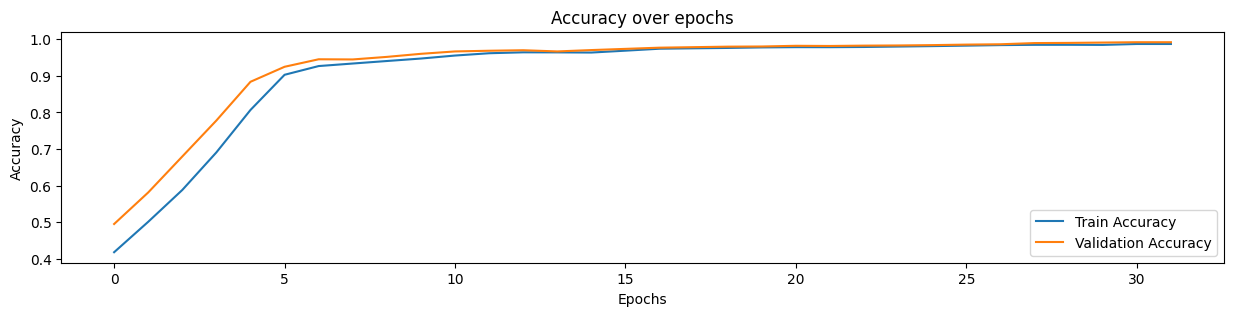

In [14]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(h.history['accuracy'], label='Train Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

67/67 [==============================] - 0s 905us/step


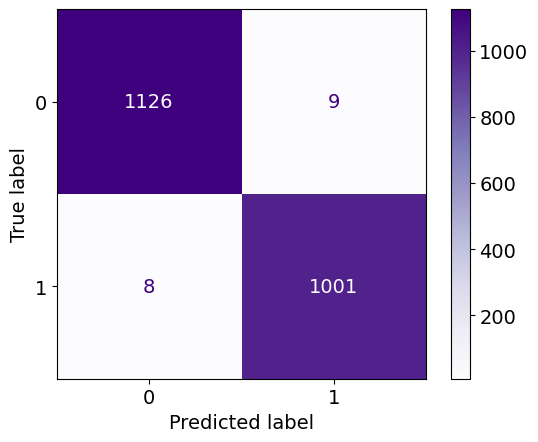

In [15]:
plt.rcParams.update({'font.size': 14})

y_pred_probs = model_QP.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test_binary, axis=1)  # Convert one-hot encoded labels to class indices


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.show()


In [16]:
model_KD = strip_pruning(model_QP)
model_KD.save("models/mnistPQKD.h5")

### Plot signal for inference @FPGA

In [ ]:
signal = [

		0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,170,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,253,101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,207,253,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,207,253,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208,254,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,207,253,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,207,253,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,224,253,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,254,254,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,253,253,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147,253,177,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,230,253,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,245,254,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,170,253,232,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,253,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,254,253,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,119,255,241,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,254,215,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,142,254,253,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,254,168,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

    ]

imageArray = np.array(signal)
image_2d = imageArray.reshape((28, 28))
# Display as an image
plt.imshow(image_2d, cmap='gray', interpolation='nearest')
plt.colorbar()  # Optional: Show color scale
plt.show()

---
Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy